# 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

False

`(2) 기본 라이브러리`

In [2]:
import re
import os, json
from glob import glob

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_core.documents import Document

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.tools import tool
from typing import List


In [4]:
os.getcwd()

'/Users/hwanghuijeong/Documents/GitHub/rag_study/project'

In [5]:
os.chdir('/Users/hwanghuijeong/Documents/GitHub/rag_study/project')

#  2. 도구 호출

###  법률 정보 검색 도구, 웹 검색 도구 정의

In [6]:

# 문서 임베딩 모델
embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Re-rank 모델
rerank_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
cross_reranker = CrossEncoderReranker(model=rerank_model, top_n=2)



### 도로교통법 검색 


In [7]:
road_traffic_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="road_traffic_law",
    persist_directory="../chroma_db",
)

road_traffic_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=road_traffic_db.as_retriever(search_kwargs={"k":5}),
)

@tool
def road_traffic_law_search(query: str) -> List[Document]:
    """도로교통법 법률 조항을 검색합니다."""
    docs = road_traffic_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 전자상거래법 검색 


In [8]:
ecommerce_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="ecommerce_law_v2",
    persist_directory="../chroma_db",
)

ecommerce_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=ecommerce_db.as_retriever(search_kwargs={"k":5}),
)


@tool
def ecommerce_law_search(query: str) -> List[Document]:
    """전자상거래 소비자보호법 법률 조항을 검색합니다."""
    docs = ecommerce_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 소비자기본법 검색 

In [9]:
cust_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="cust_law",
    persist_directory="./chroma_db_cust_law",
)

cust_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=cust_db.as_retriever(search_kwargs={"k":5}),
)


@tool
def cust_db_search(query: str) -> List[Document]:
    """소비자 기본법 법률 조항을 검색합니다."""
    docs = cust_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 주택임대차보호법 검색 


In [10]:
housing_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="housing_law",
    persist_directory="../chroma_db",
)

housing_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=housing_db.as_retriever(search_kwargs={"k":5}),
)



@tool
def housing_law_search(query: str) -> List[Document]:
    """주택임대차보호법 법률 조항을 검색합니다."""
    docs = housing_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]




### 웹 검색


In [11]:
web_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=TavilySearchAPIRetriever(k=10),
)

@tool
def web_search(query: str) -> List[str]:
    """데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다."""

    docs = web_retriever.invoke(query)

    formatted_docs = []
    for doc in docs:
        formatted_docs.append(
            Document(
                page_content= f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>',
                metadata={"source": "web search", "url": doc.metadata["source"]}
            )
        )

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [16]:
# 도구 목록을 정의 
tools = [ecommerce_law_search, cust_db_search, road_traffic_law_search, housing_law_search, web_search]

### 3-2. LLM 모델 Tool Calling

In [12]:
import os, getpass

def _set_env(var: str):
    os.environ[var] = getpass.getpass(f"{var}: ")

In [13]:
_set_env("OPENAI_API_KEY")

In [14]:
_set_env("TAVILY_API_KEY")

In [17]:
from langchain_openai import ChatOpenAI

# # LLM 
llm = ChatOpenAI(model="gpt-4.1", temperature=0, streaming=True)

# # LLM에 도구 바인딩하여 추가 
# llm_with_tools = llm.bind_tools(tools)

from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate  # 혹은 SystemMessagePromptTemplate 등

# 프롬프트 예시 (시스템 프롬프트 역할)
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "너는 법률 상담 전문가야. 사용자의 질문에 따라 적절한 도구를 반드시 사용해 답변해."),
    ("human", "{input}"),
    ("ai", "{agent_scratchpad}")  # 에이전트가 툴을 호출하거나 reasoning(중간 추론)할 때 쌓이는 기록
])


# 에이전트 생성 시 prompt 추가
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [66]:

# 사용 예시
query = "전자제품은 개봉 시 환불이 안된다고 하는데, 물건이 불량이었을 때도 동일한가요?" #"중고거래를 했는데 물품을 전달받지 못했어요."
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `ecommerce_law_search` with `{'query': '전자제품 개봉 후 환불 불가, 불량품 환불'}`


[Document(id='f1d81822-4da8-4041-a80d-0959f11fd94e', metadata={'source': '공정거래위원회_소비자민원', 'chapter': '', 'name': '생활법령소비자QnA'}, page_content='question: 1) 봉제불량\n answer: 무상수리,교환,환급 순으로 보상이 가능하며 수리 불가능 시는 교환입니다.(단, 소비자과실 및 부주의로 인한 하자이거나 장기착화제품의 경우 보상 제외이며,품질보증기간 이내 제품은 구입가 기준, 품질보증기간 경과 제품은 감가함(세탁업배상비율 참조) '), Document(id='4c76f5bc-1eea-4a36-ab1d-9df8944618d1', metadata={'source': '공정거래위원회_소비자민원', 'chapter': '등산화', 'name': '생활법령소비자QnA'}, page_content='question: 1) 봉제불량\n answer: 무상수리,교환,환급 순으로 보상이 가능하며 수리 불가능 시는 교환입니다.(단, 소비자과실 및 부주의로 인한 하자이거나 장기착화제품의 경우 보상 제외이며,품질보증기간 이내 제품은 구입가 기준, 품질보증기간 경과 제품은 감가함(세탁업배상비율 참조) ')]
Invoking: `cust_db_search` with `{'query': '전자제품 불량 환불'}`


[Document(id='eec5e9a2-a6ba-4f41-888e-8f6f2ec9f9aa', metadata={'source': '소비자기본법(법률)(제20301호)(20250101).pdf', 'name': '소비자기본법', 'chapter': '제7장 소비자안전\n         제1절 총칙'}, page_content='[법률정보]\n다음 조

In [ ]:

# 사용 예시
query = "영업정지 대신 과징금 부여하는 기준을 알려주세요."
response = agent_executor.invoke({"input": query})

In [67]:
# 모호한 질문을 하는 경우 
query = "과징금 부여기준을 알려주세요."
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `web_search` with `{'query': '과징금 부여기준'}`


[Document(metadata={'source': 'web search', 'url': 'https://www.lawmaking.go.kr/lmKnlg/jdgStd/info?astSeq=2232'}, page_content='<Document href="https://www.lawmaking.go.kr/lmKnlg/jdgStd/info?astSeq=2232"/>\n자격 부여; 21. 외국인의 지위 ... 제21조(과징금 부과기준 등) ① 법 제27조에 따른 위반행위의 종류와 위반 정도에 따른 과징금의 금액은 별표 1과 같다. ② 시·도지사는 제1항에 따라 과징금을 부과하는 경우 위반행위의 정도, 위반횟수, 위반행위의 동기와 그\n</Document>'), Document(metadata={'source': 'web search', 'url': 'https://namu.wiki/w/과징금'}, page_content='<Document href="https://namu.wiki/w/과징금"/>\n제28조(과징금의 기준) ① 행정청은 법령등에 따른 의무를 위반한 자에 대하여 법률로 정하는 바에 따라 그 위반행위에 대한 제재로서 과징금을 부과할 수 있다. ② 과징금의 근거가 되는 법률에는 과징금에 관한 다음 각 호의 사항을 명확하게 규정하여야 한다. 1.\n</Document>')]과징금 부여기준은 일반적으로 다음과 같이 정해집니다.

1. 법적 근거
- 과징금은 각 법률(예: 공정거래법, 전자상거래법 등)에 따라 부과할 수 있으며, 해당 법률에 과징금의 부과 기준, 금액, 절차 등이 명확히 규정되어 있습니다.

2. 부과 기준
- 위반행위의 종류와 위반 정도에 따라 과징금의 금액이 달라집니다.
- 위반행위의 정도, 위반 횟수, 위반 동기, 위반으로 인한 결과 등을 종합적으로 고려하여 결정합니다

In [68]:

query = "영업정지 대신 과징금 부여하는 기준을 알려주세요."
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `web_search` with `{'query': '영업정지 대신 과징금 부여 기준'}`


[Document(metadata={'source': 'web search', 'url': 'https://blog.naver.com/tarot_sinsu/223867783857'}, page_content='<Document href="https://blog.naver.com/tarot_sinsu/223867783857"/>\n영업정지 처분을 갈음한 과징금 처분 ... 법적 근거: 영업정지 대신 과징금 부과의 기준 . 화관법 제28조 및 관련 법령에 따르면, 관할 당국은 특정 상황에서 영업정지 처분 대신 과징금을 부과할 수 있습니다. 해당 조항에 따른 주요 기준은 다음과 같습니다.\n</Document>'), Document(metadata={'source': 'web search', 'url': 'https://m.blog.naver.com/lawagency/222142446942'}, page_content='<Document href="https://m.blog.naver.com/lawagency/222142446942"/>\n(1) 영업정지를 대신하는 과징금 부과의 기준이 되는 매출금액은? 처분일이 속한 연도의 전년도의 1년간 총매출금액을 기준으로 합니다. 예외) 휴업이나 신규 사업 등으로 인하여 1년간의 총매출금액을 산출할 수 없는 경우에는 분기별·월별 또는 일별 매출\n</Document>')]영업정지 처분을 갈음하여 과징금을 부과하는 기준은 다음과 같습니다.

1. 법적 근거
- 각 개별 법률(예: 화학물질관리법, 식품위생법, 공정거래법 등)에 따라 영업정지 처분을 대신해 과징금을 부과할 수 있는 근거가 마련되어 있습니다.

2. 과징금 산정 기준
- 과징금은 보통 “처분일이 속한 연도의 전년도 1년간 총매출금액”을 기준으로 산정합니다.
- 만약 1년간의 총매출금

In [71]:

query = "오늘은 몇일인가요?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...
오늘 날짜를 확인하려면 사용 중인 기기의 날짜나 캘린더를 참고해 주세요. 저는 실시간 날짜 정보를 직접 제공할 수 없습니다. 추가로 궁금한 점이 있으시면 말씀해 주세요!

> Finished chain.


In [73]:
# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "연차휴가 부여 기준에 대해서 설명해주세요. 2023년 연차휴가 사용 비율은 어느 정도인가요?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `web_search` with `{'query': '연차휴가 부여 기준 법률 근거 및 설명'}`


[Document(metadata={'source': 'web search', 'url': 'https://touo.tistory.com/189'}, page_content='<Document href="https://touo.tistory.com/189"/>\n📌 연차 발생 기준 및 법적 근거. 연차 휴가는 근로기준법 제60조에 근거하여 발생하며, 기본적으로 근속 기간에 비례하여 부여됩니다.. 연차 발생 조건. 1년간 출근율 80% 이상 근무한 근로자에게 연차 휴가 발생 근속 기간에 따라 연차 일수 증가 정규직·계약직·파견근로자 모두 적용 (단, 일부 특수\n</Document>'), Document(metadata={'source': 'web search', 'url': 'https://blog.naver.com/PostView.naver?blogId=jambba&logNo=223573677463'}, page_content='<Document href="https://blog.naver.com/PostView.naver?blogId=jambba&logNo=223573677463"/>\n그럼 지금부터 연차휴가 발생 기준 과 구체적인 사용법에 대해 자세히 알아보겠습니다. 연차유급휴가 발생 기준: 근로기준법 제60조 완벽 해설 연차유급휴가 는 근로기준법 제60조 에 따라 발생하며, 그 기준은 근로자가 1년간 80% 이상 출근 했을 때 부여됩니다.\n</Document>')]
Invoking: `web_search` with `{'query': '2023년 연차휴가 사용 비율 통계'}`


[Document(metadata={'source': 'web search', 'url': 'https://www.datanews.co.kr/news/article.html?no=137

In [74]:
# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "운전면허 결격사유는 무엇인가요?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `road_traffic_law_search` with `{'query': '운전면허 결격사유'}`


[Document(metadata={'chapter': '제8장 운전면허', 'name': '도로교통법', 'source': 'data/도로교통법(법률)(제20375호)(20250320).pdf'}, page_content='[법률정보]\n다음 조항은 도로교통법 제8장 운전면허에서 발췌한 내용입니다.\n\n[법률조항]\n제94조의2(범죄경력조회 및 수사경력조회) 시ㆍ도경찰청장은 제82조제2항 각 호의 어느 하나의 경우에 해당하는 사람\n이 운전면허 결격사유가 된 법률 위반과 관련하여 같은 항 단서에 해당하는 확정판결 또는 처분을 받았는지 여부와\n제93조제1항 또는 제2항에 따라 운전면허가 취소ㆍ정지된 사람이 그 처분의 원인이 된 법률 위반과 관련하여 무죄\n의 확정판결 또는 불기소처분을 받았는지 여부를 확인하기 위하여 「형의 실효 등에 관한 법률」 제6조에 따른 범죄\n경력조회 및 수사경력조회를 할 수 있다.\n[본조신설 2021. 1. 12.]'), Document(metadata={'chapter': '제8장 운전면허', 'name': '도로교통법', 'source': 'data/도로교통법(법률)(제20375호)(20250320).pdf'}, page_content='[법률정보]\n다음 조항은 도로교통법 제8장 운전면허에서 발췌한 내용입니다.\n\n[법률조항]\n제80조의2(음주운전 방지장치 부착 조건부 운전면허) ① 제44조제1항, 제2항 또는 제5항을 위반(자동차등 또는 노면전\n차를 운전한 경우로 한정한다. 다만, 개인형 이동장치를 운전한 경우는 제외한다. 이하 같다)한 날부터 5년 이내에 다\n시 같은 조 제1항, 제2항 또는 제5항을 위반하여 운전면허 취소처분을 받은 사람이 자동차등을 운전하려는 경우에는\n시ㆍ도경찰청장으로부터 음주운전 방지장치 부착 조건

# 3. Agent RAG 구현 

- 각 법률에 특화된 RAG 에이전트 구현 
- 라우팅: 질문에 따라 적합한 에이전트 호출
- 생성된 답변에 대한 피드백을 제공
- 필요한 경우 사람의 피드백을 요청 (답변이 애매한 경우 - 재검색 여부 판단)


### 3-1. 법률별 특화 RAG 에이전트 구현 
- 질문에 따라 참조문서의 관련성을 높이기 위해 법률별 에이전트 생성
- 검색된 문서의 관련성 등을 평가하여 질문 재작성 및 다시 검색 (Corrective RAG 적용)

#### (1) 전자상거래법 RAG 에이전트

In [18]:
from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Optional
from operator import add
from langchain_core.documents import Document

class CorrectiveRagState(TypedDict):
    question: str                 # 사용자의 질문
    generation: str               # LLM 생성 답변
    documents: List[Document]     # 컨텍스트 문서 (검색된 문서)
    num_generations: int          # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)

class InformationStrip(BaseModel):
    """추출된 정보에 대한 내용과 출처, 관련성 점수"""
    content: str = Field(..., description="추출된 정보 내용")
    source: str = Field(..., description="정보의 출처(법률 조항 또는 URL 등). 예시: 환경법 제22조 3항 or 블로그 환경법 개정 (https://blog.com/page/123)")
    relevance_score: float = Field(..., ge=0, le=1, description="관련성 점수 (0에서 1 사이)")
    faithfulness_score: float = Field(..., ge=0, le=1, description="충실성 점수 (0에서 1 사이)")

class ExtractedInformation(BaseModel):
    strips: List[InformationStrip] = Field(..., description="추출된 정보 조각들")
    query_relevance: float = Field(..., ge=0, le=1, description="질의에 대한 전반전인 답변 가능성 점수 (0에서 1 사이)")

class RefinedQuestion(BaseModel):
    """개선된 질문과 이유"""
    question_refined : str = Field(..., description="개선된 질문")
    reason : str = Field(..., description="이유")

# 전자상거래법
class EcommerceRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str]


In [ ]:
# from langchain_core.prompts import ChatPromptTemplate
# from typing import Literal

# def retrieve_documents(state: EcommerceRagState) -> EcommerceRagState:
#     print("---문서 검색---")
#     query = state.get("rewritten_query", state["question"])
#     docs = road_traffic_law_search.invoke(query)
#     return {"documents": docs}

# def extract_and_evaluate_information(state: EcommerceRagState) -> EcommerceRagState:
#     print("---정보 추출 및 평가---")
#     extracted_strips = []

#     for doc in state["documents"]:
#         extract_prompt = ChatPromptTemplate.from_messages([
#             ("system", """당신은 소비자 관련 전자상거래법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
#             각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
#             1. 질문과의 관련성
#             2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
#             추출 형식:
#             1. [추출된 정보]
#             - 관련성 점수: [0-1 사이의 점수]
#             - 충실성 점수: [0-1 사이의 점수]
#             2. [추출된 정보]
#             - 관련성 점수: [0-1 사이의 점수]
#             - 충실성 점수: [0-1 사이의 점수]
#             ...
            
#             마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
#             ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
#         ])

#         extract_llm = llm.with_structured_output(ExtractedInformation)

#         extracted_data = extract_llm.invoke(extract_prompt.format(
#             question=state["question"],
#             document_content=doc.page_content
#         ))

#         if extracted_data.query_relevance < 0.8:
#             continue

#         for strip in extracted_data.strips:
#             if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
#                 extracted_strips.append(strip)

#     return {
#         "extracted_info": extracted_strips,
#         "num_generations": state.get("num_generations", 0) + 1
#     }

# def rewrite_query(state: EcommerceRagState) -> EcommerceRagState:
#     print("---쿼리 재작성---")

#     rewrite_prompt = ChatPromptTemplate.from_messages([
#         ("system", """당신은 개인정보보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

#         다음 사항을 고려하여 검색 쿼리를 개선하세요:
#         1. 원래 질문의 핵심 요소
#         2. 추출된 정보의 관련성 점수
#         3. 추출된 정보의 충실성 점수
#         4. 부족한 정보나 더 자세히 알아야 할 부분

#         개선된 검색 쿼리 작성 단계:
#         1. 2-3개의 검색 쿼리를 제안하세요.
#         2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
#         3. 개인정보보호법과 관련된 전문 용어를 적절히 활용하세요.
#         4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

#         출력 형식:
#         1. [개선된 검색 쿼리 1]
#         - 이유: [이 쿼리를 제안한 이유 설명]
#         2. [개선된 검색 쿼리 2]
#         - 이유: [이 쿼리를 제안한 이유 설명]
#         3. [개선된 검색 쿼리 3]
#         - 이유: [이 쿼리를 제안한 이유 설명]

#         마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
#         ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
#     ])

#     extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
#     rewrite_llm = llm.with_structured_output(RefinedQuestion)

#     response = rewrite_llm.invoke(rewrite_prompt.format(
#         question=state["question"],
#         extracted_info=extracted_info_str
#     ))
    
#     return {"rewritten_query": response.question_refined}

# def generate_node_answer(state: EcommerceRagState) -> EcommerceRagState:
#     print("---답변 생성---")

#     answer_prompt = ChatPromptTemplate.from_messages([
#         ("system", """당신은 개인정보보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
#         답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
#         답변 구조:
#         1. 질문에 대한 직접적인 답변
#         2. 관련 법률 조항 및 해석
#         3. 추가 설명 또는 예시 (필요한 경우)
#         4. 결론 및 요약
#         각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 개인정보 보호법 제15조)"""),
#         ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
#     ])

#     extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

#     node_answer = llm.invoke(answer_prompt.format(
#         question=state["question"],
#         extracted_info=extracted_info_str
#     ))

#     return {"node_answer": node_answer.content}

# def should_continue(state: EcommerceRagState) -> Literal["계속", "종료"]:
#     if state["num_generations"] >= 2:
#         return "종료"
#     if len(state["extracted_info"]) >= 1:
#         return "종료"
#     return "계속"

In [ ]:
### 멀티 홉 구조 추가 (2025.06.11), 프롬프트 변경 (2025.06.13)
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from langchain_core.documents import Document

# 전자상거래법 문서 검색
def retrieve_documents(state: EcommerceRagState) -> EcommerceRagState:
    print("---문서 검색 (전자상거래법)---")
    query = state.get("rewritten_query", state["question"])
    docs = ecommerce_law_search.invoke(query)
    return {"documents": docs}

# 정보 추출 및 평가 (전자상거래법)
def extract_and_evaluate_information(state: EcommerceRagState) -> EcommerceRagState:
    print("---정보 추출 및 평가 (전자상거래법)---")
    extracted_strips = []

    for doc in state["documents"]:
        source = doc.metadata.get("source") or doc.metadata.get("name") or "출처를 알 수 없음"

        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 소비자 관련 전자상거래법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])
        extract_llm = llm.with_structured_output(ExtractedInformation)
        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(InformationStrip(
                    content=strip.content,
                    source=source,
                    relevance_score=strip.relevance_score,
                    faithfulness_score=strip.faithfulness_score
                ))

    return {
        **state,
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: EcommerceRagState) -> EcommerceRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 전자상거래법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 전자상거래법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}


# 소비자기본법 문서 검색
def retrieve_consumer_law(state: EcommerceRagState) -> EcommerceRagState:
    print("---문서 검색 (소비자기본법)---")
    query = state["question"] + "\n" + state["node_answer"]
    cust_law_docs = cust_db.similarity_search(query, k=3)

    cust_docs = []
    for doc in cust_law_docs:
        source_info = (
            doc.metadata.get("source")      # ex.생활법령정보 백문백답, 공정거래위원회_소비자민원
            or doc.metadata.get("name")     # ex.생활법령소비자QnA
            or "출처를 알 수 없음"
        )
        doc_info = Document(
            page_content=doc.page_content,
            metadata={**doc.metadata, "source_id": source_info}
        )
        cust_docs.append(doc_info)

    return {
        **state,
        "consumer_documents": cust_docs
    }

#정보 추출 및 평가 (소비자기본법)
def extract_and_evaluate_consumer_info(state: EcommerceRagState) -> EcommerceRagState:
    print("---정보 추출 및 평가 (소비자기본법)---")
    extracted_strips = []

    for doc in state.get("consumer_documents", []):
        source = doc.metadata.get("source") or doc.metadata.get("name") or "출처를 알 수 없음"

        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 소비자기본법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])
        extract_llm = llm.with_structured_output(ExtractedInformation)
        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(InformationStrip(
                    content=strip.content,
                    source=source,
                    relevance_score=strip.relevance_score,
                    faithfulness_score=strip.faithfulness_score
                ))

    return {
        **state,
        "consumer_extracted_info": extracted_strips
    }

# 답변 생성
def generate_node_answer(state: EcommerceRagState) -> EcommerceRagState:
    print("---1차 답변 생성 (전자상거래법 기반)---")

    if not state.get("extracted_info"):
        return {"node_answer": "관련 정보를 찾을 수 없습니다."}

    extracted_info_str = "\n".join([
        f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}"
        for strip in state["extracted_info"]
    ])

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 전자상거래법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 일반 텍스트 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 법률 조항 및 해석
        2. 질문과 관련된 사례 혹은 법률 외 qna 정보
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        
        마지막 줄에 다음 형식으로 관련 법령을 JSON 배열로 명시하세요.  
        예: 관련 법령: ["전자상거래법 제17조"]
        """),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {**state, "node_answer": node_answer.content}

# 통합 답변 생성
def generate_combined_answer(state: EcommerceRagState) -> EcommerceRagState:
    print("---최종 통합 답변 생성---")

    consumer_strips = state.get("consumer_extracted_info", [])
    consumer_content = "\n".join([
        f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}"
        for strip in consumer_strips
    ]) if consumer_strips else "(소비자기본법 관련 정보 없음)"

    prompt = f"""
    질문: {state['question']}

    [1차 답변 - 전자상거래법 기반]
    {state['node_answer']}

    [보완 문서 - 소비자기본법 기반]
    {consumer_content}

    위 내용을 종합하여 일반 텍스트 형식으로 작성해 주세요. 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 법률 조항 및 해석
        2. 질문과 관련된 사례 혹은 법률 외 qna 정보
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        
    마지막 줄에 다음 형식으로 관련 법령을 JSON 배열로 명시하세요.  
    예: 관련 법령: ["전자상거래법 제17조", "소비자기본법 제10조"]
    """
    response = llm.invoke(prompt)
    return {
        **state,
        "node_answer": response.content
    }

# 루프 제어
def should_continue(state: EcommerceRagState) -> Literal["계속", "종료"]:
    if state.get("num_generations", 0) >= 2:
        return "종료"
    if len(state.get("extracted_info", [])) >= 1:
        return "종료"
    return "계속"

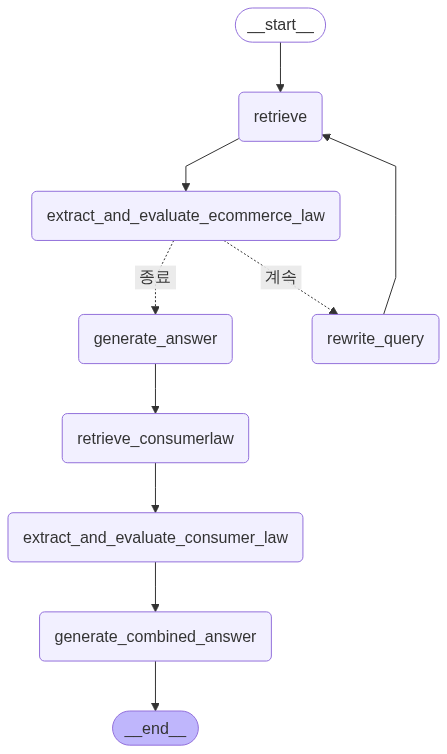

In [172]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(EcommerceRagState)

# 노드 등록
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate_ecommerce_law", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)
workflow.add_node("retrieve_consumerlaw", retrieve_consumer_law)
workflow.add_node("extract_and_evaluate_consumer_law", extract_and_evaluate_consumer_info)
workflow.add_node("generate_combined_answer", generate_combined_answer)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate_ecommerce_law")

# 조건부 루프 제어 (전자상거래법 정보 부족 시 재검색)
workflow.add_conditional_edges(
    "extract_and_evaluate_ecommerce_law",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)

workflow.add_edge("rewrite_query", "retrieve")

# 소비자기본법 흐름
workflow.add_edge("generate_answer", "retrieve_consumerlaw")
workflow.add_edge("retrieve_consumerlaw", "extract_and_evaluate_consumer_law")
workflow.add_edge("extract_and_evaluate_consumer_law", "generate_combined_answer")

# 종료
workflow.add_edge("generate_combined_answer", END)

# 컴파일
ecommerce_law_agent = workflow.compile()


# 그래프 시각화
display(Image(ecommerce_law_agent.get_graph().draw_mermaid_png()))

In [173]:
inputs = {"question": "환불이 거절되었을 때 소비자가 취할 수 있는 조치가 있나요?"}
for output in ecommerce_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색 (전자상거래법)---
"Node 'retrieve':"
("Value: {'documents': [Document(id='d88c096a-e5ec-45a0-bcac-0cc6fee575ff', "
 "metadata={'url': "
 "'https://www.easylaw.go.kr/CSP/OnhunqueansInfoRetrieve.laf?onhunqnaAstSeq=88&onhunqueSeq=3131', "
 "'chapter': '소비자 > 소비자분쟁해결', 'name': '생활법령소비자QnA', 'source': '생활법령정보 백문백답'}, "
 "page_content='Q: 인터넷 쇼핑몰에서 물건을 샀는데 사업자가 반품을 거부하고 있습니다. 이런 문제가 발생하면 어떻게 해결할 수 "
 '있나요?\\nA: ◇ 소비자는 물품 또는 서비스의 거래 및 사용 과정에서 피해를 입은 경우에는 사업자와 직접 면담해서 피해를 구제받을 수 '
 '있습니다.\\n그러나 사업자가 이를 거부하는 경우에는 국가 및 지방자치단체에서 운영하는 소비자피해구제기구, 공정거래위원회에 등록된 '
 '소비자단체, 소비자단체협의체(www.consumer.or.kr), 각종 분쟁조정위원회, 한국소비자원(www.kca.go.kr)에 의뢰해서 '
 '피해를 구제받을 수 있으며 소송 등의 방법을 이용할 수도 있습니다.\\n◇ 소비자상담을 원하는 경우 1372 소비자상담센터를 이용할 수 '
 "있습니다.\\n전화상담: 전국 어디서나 국번 없이 1372번\\n인터넷 상담 :www.ccn.go.kr'), "
 "Document(id='721282c4-ce6c-4d5e-9e6c-a581a0fba665', metadata={'source': "
 "'공정거래위원회_소비자민원', 'name': '생활법령소비자QnA', 'chapter': ''}, "
 "page_content='question: 1) 신유형 상품권의 구매일로부터 7일이내에 환급을 요구하였으나 거부하는 경우\\n "
 "answ

In [174]:
print(value['node_answer'])

1. 질문에 대한 법률 조항 및 해석  
전자상거래 등에서의 소비자보호에 관한 법률(이하 "전자상거래법") 제17조와 제18조에 따르면, 소비자는 일정 기간(통상 상품 수령일로부터 7일 이내) 내에 청약철회, 즉 환불을 요구할 수 있습니다. 만약 사업자가 정당한 사유 없이 환불을 거부한다면, 이는 법 위반에 해당할 수 있으며, 소비자는 법적으로 보호받을 권리가 있습니다. 특히, 신유형 상품권 등 일부 상품의 경우에는 구매일로부터 7일 이내 환급을 요구할 수 있고, 사업자는 이를 거부할 수 없습니다(출처: 공정거래위원회 소비자민원, 전자상거래법).

2. 질문과 관련된 사례 혹은 법률 외 Q&A 정보  
환불이 거절된 경우, 소비자는 다음과 같은 절차를 통해 피해 구제를 요청할 수 있습니다(출처: 생활법령정보, 1372 소비자상담센터):
- 사업자와 직접 협의하여 환불 등 피해 구제를 요청
- 1372 소비자상담센터(전화 1372, 인터넷 www.ccn.go.kr)를 통한 상담 및 안내
- 한국소비자원, 공정거래위원회, 지방자치단체 소비자보호센터 등 소비자피해구제기구에 분쟁조정 신청
- 소비자단체, 분쟁조정위원회 등 외부 기관을 통한 중재 요청
- 필요시 법원에 소송 제기

3. 추가 설명 또는 예시  
예를 들어, 온라인 쇼핑몰에서 상품을 구매한 후 7일 이내에 환불을 요청했으나 사업자가 이를 거부한 경우, 우선 사업자와 직접 협의해볼 수 있습니다. 협의가 원만히 이루어지지 않으면 1372 소비자상담센터에 상담을 신청하거나, 한국소비자원에 분쟁조정을 신청할 수 있습니다. 만약 이 과정에서도 해결이 되지 않는다면, 법적 절차(소송)를 통해 피해 구제를 받을 수 있습니다.

4. 결론 및 요약  
환불이 거절된 경우, 소비자는 사업자와의 직접 협의, 1372 소비자상담센터 상담, 한국소비자원 등 소비자피해구제기구를 통한 분쟁조정, 그리고 법적 절차(소송) 등 다양한 방법으로 피해 구제를 요청할 수 있습니다. 특히, 전자상거래법상 정해진 청약철회 기간 내에는 소비자

#### (3) 주택임대차보호법 RAG 에이전트

In [23]:
# 주택임대차보호법
class HousingRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [24]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: HousingRagState) -> HousingRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = housing_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: HousingRagState) -> HousingRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: HousingRagState) -> HousingRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 주택임대차보호법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: HousingRagState) -> HousingRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 주택임대차보호법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: HousingRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

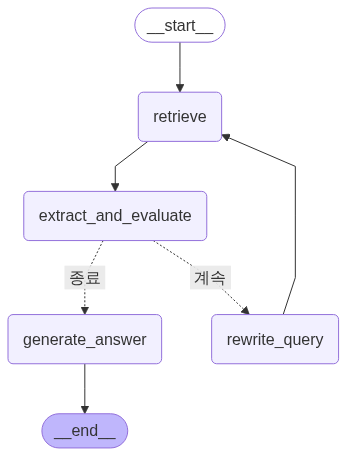

In [25]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(HousingRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
housing_law_agent = workflow.compile()

# 그래프 시각화
display(Image(housing_law_agent.get_graph().draw_mermaid_png()))

In [25]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in housing_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'name': '주택임대차보호법', "
 "'source': 'data/주택임대차보호법(법률)(제19356호)(20230719).pdf'}, "
 "page_content='[법률정보]\\n다음 조항은 주택임대차보호법에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제3조의7(임대인의 정보 제시 의무) 임대차계약을 체결할 때 임대인은 다음 각 호의 사항을 '
 '임차인에게 제시하여야 한\\n다.\\n1. 제3조의6제3항에 따른 해당 주택의 확정일자 부여일, 차임 및 보증금 등 정보. 다만, '
 '임대인이 임대차계약을 체결\\n하기 전에 제3조의6제4항에 따라 동의함으로써 이를 갈음할 수 있다. \\n2. 「국세징수법」 제108조에 '
 '따른 납세증명서 및 「지방세징수법」 제5조제2항에 따른 납세증명서. 다만, 임대인이 임\\n대차계약을 체결하기 전에 「국세징수법」 '
 '제109조제1항에 따른 미납국세와 체납액의 열람 및 「지방세징수법」 제 \\n6조제1항에 따른 미납지방세의 열람에 각각 동의함으로써 이를 '
 "갈음할 수 있다. \\n[본조신설 2023. 4. 18.]'), Document(metadata={'name': "
 "'주택임대차보호법', 'source': "
 "'data/주택임대차보호법(법률)(제19356호)(20230719).pdf'}, "
 "page_content='[법률정보]\\n다음 조항은 주택임대차보호법에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제30조(주택임대차표준계약서 사용) 주택임대차계약을 서면으로 체결할 때에는 법무부장관이 '
 '국토교통부장관과 협의\\n하여 정하는 주택임대차표준계약서를 우선적으로 사용한다. 다만, 당사자가 다른 서식

In [26]:
print(value['node_answer'])

1. 질문에 대한 직접적인 답변  
아파트 임대차 계약을 대리인과 체결할 때는 임대인의 대리인임을 확인하고, 임대인의 정보(확정일자, 차임, 보증금, 국세 및 지방세 납세증명서 등)를 반드시 확인해야 합니다. 대리인과 계약하더라도 임대인의 정보 제공 의무는 동일하게 적용되므로, 관련 서류를 꼼꼼히 확인하는 것이 중요합니다. (출처: 주택임대차보호법 제3조의7 해석)

2. 관련 법률 조항 및 해석  
- 주택임대차보호법 제3조의7 제1호에 따르면, 임대인은 임차인에게 확정일자 부여일, 차임, 보증금 등 주요 정보를 제시해야 하며, 임대인이 계약 전에 동의하면 생략할 수 있습니다.  
- 제3조의7 제2호에서는 임대인이 국세 및 지방세 납세증명서를 임차인에게 제시해야 한다고 규정하고 있습니다. 단, 임대인이 미납세 열람에 동의하면 증명서 제시를 생략할 수 있습니다.  
- 이 의무는 대리인을 통한 계약에도 동일하게 적용되므로, 대리인과 계약할 때도 임대인의 정보를 반드시 확인해야 합니다. (출처: 주택임대차보호법 제3조의7 제1호, 제2호, 해석)

3. 추가 설명 또는 예시  
예를 들어, 임대인의 가족이나 부동산 중개업자가 임대인의 대리인 자격으로 계약을 체결하는 경우, 임차인은 대리인의 신분(위임장 등)과 함께 임대인의 확정일자, 차임, 보증금, 납세증명서 등 관련 서류를 요구할 수 있습니다. 만약 임대인이 미납세 열람에 동의했다면, 별도의 증명서 없이도 임차인이 세금 체납 여부를 확인할 수 있습니다. (출처: 주택임대차보호법 제3조의7 해석)

4. 결론 및 요약  
아파트 임대차 계약을 대리인과 체결할 때는 대리인의 자격을 확인하고, 임대인의 정보(확정일자, 차임, 보증금, 납세증명서 등)를 반드시 확인해야 합니다. 이는 임대차보호법상 임대인의 정보 제공 의무가 대리인 계약에도 동일하게 적용되기 때문입니다. 꼼꼼한 서류 확인을 통해 향후 분쟁을 예방할 수 있습니다. (출처: 주택임대차보호법 제3조의7 제1호, 제2호, 해석)


#### (4) 웹 검색 기반 RAG 에이전트

In [26]:
# 웹 검색 도구 
class SearchRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [27]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: SearchRagState) -> SearchRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = web_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: SearchRagState) -> SearchRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: SearchRagState) -> SearchRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 질문과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: SearchRagState) -> SearchRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 출처 및 링크
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 블로그 (www.blog.com/page/001)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: SearchRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

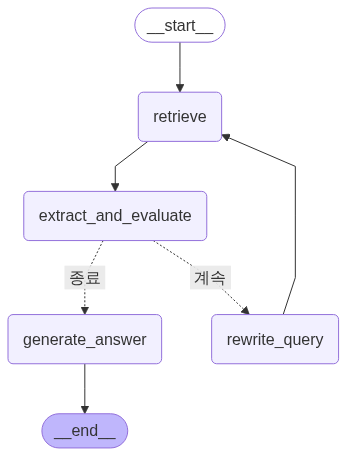

In [28]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(SearchRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
search_web_agent = workflow.compile()

# 그래프 시각화
display(Image(search_web_agent.get_graph().draw_mermaid_png()))

In [30]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in search_web_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'source': 'web search', 'url': "
 "'https://m.blog.naver.com/mathmaster7668/223053556755'}, "
 "page_content='<Document "
 'href="https://m.blog.naver.com/mathmaster7668/223053556755"/>\\n카테고리 이동 집주인 '
 '대신 대리인과 임대차계약시 주의할 점 5가지 Q. 집주인 대신 대리인과 임대차계약시 주의할 점은? 그러나, 현업에 있다 보면 부득이 하게 '
 '임대인 또는 매도인이 대리인을 내보내는 경우가 종종 있습니다. 대리 임대차계약시 주의사항 5가지 임대차 계약이라면, 그리고 반드시 '
 '위임장에는 일반도장이 아닌 임대인(집주인)의 인감도장이 날인되어야 합니다. 3. 계약서 특약에 명시 임대차계약을 체결한 계약 상대방은  '
 "소유자가 아닌  \\'소유자의 대리인\\'이기 때문입니다. 임대차 대리계약 요약! 3. 계약서 특약에 명시 민법 제118조(대리권의 "
 '범위) 제115조(본인을 위한 것임을 표시하지 아니한 행위) 대리인이 본인을 위한 것임을 표시하지 아니한 때에는 그 의사표시는 자기를 '
 '위한 것으로 본다. https://blog.naver.com/mathmaster7668/222833950660 Q. 매매계약이 진행중인 '
 "아파트 전세계약을 체결하려고 하는데, \\'부동산\\'에서 매수자(새로운 집... blog.naver.com "
 'https://blog.naver.com/mathmaster7668/222841733223 Q. 소액임차인이면 경매에서 보증금 전액 '
 '무조건 전액 다 배당 받나요? blog.naver.com '
 'https://blog.naver.com/mathmaster7668/223751180219 부동산 거래 현장에서 가장 많은

In [31]:
print(value['node_answer'])

1. 질문에 대한 직접적인 답변  
아파트 임대차 계약을 임대인의 대리인과 체결할 때는 다음 사항에 반드시 주의해야 합니다.

- 대리인이 임대인(집주인)으로부터 정식으로 위임받았음을 증명하는 ‘위임장’을 확인해야 하며, 이 위임장에는 임대인의 인감도장이 날인되어 있어야 합니다. 일반 도장이 아닌 인감도장이어야 법적 효력이 인정됩니다.  
- 임대차계약서에는 계약 상대방이 ‘소유자의 대리인’임을 특약사항에 명확히 기재해야 하며, 대리계약임을 분명히 표시해야 합니다.  
- 민법상 대리인이 본인을 위한 것임을 표시하지 않으면 그 의사표시는 대리인 자신을 위한 것으로 간주될 수 있으므로, 반드시 ‘본인을 위한 대리행위’임을 명확히 해야 합니다.  
- 분쟁 예방을 위해 계약 전후로 모든 서류와 절차를 꼼꼼히 확인하고, 공인중개사만을 전적으로 신뢰하여 서류를 처리하는 것은 위험할 수 있으니 주의가 필요합니다.  
- 특히, 개업공인중개사에게 임대차에 관한 권한을 위임하는 경우에는 위임 범위와 권한을 명확히 확인해야 합니다.  

2. 관련 출처 및 링크  
- 임대인 대신 대리인과 계약 시 위임장 및 인감도장 필요 (출처: 네이버 블로그, https://m.blog.naver.com/mathmaster7668/223053556755)  
- 계약서에 ‘소유자의 대리인’임을 명시해야 함 (출처: 네이버 블로그, https://m.blog.naver.com/mathmaster7668/223053556755)  
- 민법 제118조, 제115조 관련 대리계약 표시의 중요성 (출처: 네이버 블로그, https://m.blog.naver.com/mathmaster7668/223053556755)  
- 분쟁 예방 및 공인중개사 위임 시 주의사항 (출처: 네이버 블로그, https://blog.naver.com/lawyerkim20/223862706792)  

3. 추가 설명 또는 예시  
예를 들어, 임대인의 친척이나 지인이 대리인으로 나와 계약을 진행할 경우, 구두로만 

### 3-2. 질문 라우팅 
- 사용자의 질문을 분석하여 적절한 에이전트를 선택 (Adaptive RAG 적용)

In [175]:
from typing import Annotated
from operator import add

# 메인 그래프 상태 정의
class ResearchAgentState(TypedDict):
    question: str
    answers: Annotated[List[str], add]
    final_answer: str
    datasources: List[str]
    evaluation_report: Optional[dict]
    user_decision: Optional[str]

In [ ]:
# from typing import Literal
# from langchain_core.prompts import ChatPromptTemplate
# from pydantic import BaseModel, Field

# # 라우팅 결정을 위한 데이터 모델
# class ToolSelector(BaseModel):
#     """Routes the user question to the most appropriate tool."""
#     tool: Literal["search_ecommerce",  "search_housing", "search_web"] = Field(
#         description="Select one of the tools, based on the user's question.",
#     )

# class ToolSelectors(BaseModel):
#     """Select the appropriate tools that are suitable for the user question."""
#     tools: List[ToolSelector] = Field(
#         description="Select one or more tools, based on the user's question.",
#     )

# # 구조화된 출력을 위한 LLM 설정
# structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# # 라우팅을 위한 프롬프트 템플릿
# system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tools.
# Use the following guidelines:
# - For questions specifically about legal provisions or articles of the privacy protection law (개인정보 보호법), use the search_ecommerce tool.
# - For questions specifically about legal provisions or articles of the housing law (주택임대차보호법), use the search_housing tool.
# - For any other information, including questions related to these laws but not directly about specific legal provisions, or for the most up-to-date data, use the search_web tool.
# Always choose all of the appropriate tools based on the user's question. 
# If a question is about a law but doesn't seem to be asking about specific legal provisions, include both the relevant law search tool and the search_web tool.""")

# route_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system),
#         ("human", "{question}"),
#     ]
# )

# # 질문 라우터 정의
# question_tool_router = route_prompt | structured_llm_tool_selector

# # 테스트 실행
# print(question_tool_router.invoke({"question": "근로계약 체결할 때 개인정보 취급 상의 유의사항은 무엇인가요?"}))
# print(question_tool_router.invoke({"question": "법에서 정한 연차휴가 기준을 알려주세요."}))
# print(question_tool_router.invoke({"question": "개인정보보호법에서 정한 가명정보의 정의는 무엇인가요?"}))
# print(question_tool_router.invoke({"question": "전자제품은 개봉 시 환불이 안된다고 하는데, 물건이 불량이었을 때도 동일한가요?"}))
# print(question_tool_router.invoke({"question": "전세 계약 시 주의해야 할 것 알려주세요."}))

tools=[ToolSelector(tool='search_ecommerce'), ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_ecommerce')]
tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_web'), ToolSelector(tool='search_housing')]


In [176]:
############ 추가 (2025.06.06) ###############3
from typing import List, Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from textwrap import dedent

# 1. 툴 분류 모델 정의
class ToolSelector(BaseModel):
    tool: Literal["search_ecommerce", "search_housing", "search_web"] = Field(
        description="Select one of: 'search_ecommerce', 'search_housing', or 'search_web'"
    )

class ToolSelectors(BaseModel):
    tools: List[ToolSelector] = Field(
        description="Select one or more tools relevant to the user's question."
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# 3. 프롬프트 정의 (지침 + 예시 포함)
system_prompt = dedent("""
You are an AI legal assistant responsible for determining which tool to use to answer a user's question based on the legal domain involved.

Each tool corresponds to a legal category:

- 'search_ecommerce': For questions related to commerce between businesses and consumers — including online purchases, refunds, delivery issues, subscription cancellations, and consumer protection.
- 'search_housing': For questions involving residential leases, rental agreements, tenant rights, housing protections, or address registration.
- 'search_web': For questions outside specific laws (e.g., current events, general legal news, public policy, or laws unrelated to ecommerce or housing).

Make your decision based on the **legal theme and domain** of the question, not just keywords.

Examples:
- "전자제품 환불 거부에 대응하려면 어떻게 해야 하나요?" → tools = ['search_ecommerce']
- "이사하고 나서 전입신고 안 하면 어떤 불이익이 있나요?" → tools = ['search_housing']
- "쇼핑몰에서 교환을 거절하는 건 정당한가요?" → tools = ['search_ecommerce']
- "주택임대차보호법에서 임차인이 보호받는 조건은?" → tools = ['search_housing']
- "노동자 권리에 대해 알고 싶어요" → tools = ['web_search']                    
""")


route_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{question}")
])

# 4. LLM Tool Router 정의
question_tool_router = route_prompt | structured_llm_tool_selector

# 5. 최종 분기 함수
def route_datasources_tool_search(state):
    question = state["question"]
    print(f"[Routing Input] {question}")

    # LLM으로 분류
    response = question_tool_router.invoke({"question": question})
    datasources = [t.tool for t in response.tools]
    print(f"[Routing Output] {datasources}")
    return datasources

# 테스트 실행
print(question_tool_router.invoke({"question": "근로계약 체결할 때 개인정보 취급 상의 유의사항은 무엇인가요?"}))
print(question_tool_router.invoke({"question": "법에서 정한 연차휴가 기준을 알려주세요."}))
print(question_tool_router.invoke({"question": "개인정보보호법에서 정한 가명정보의 정의는 무엇인가요?"}))
print(question_tool_router.invoke({"question": "전자제품은 개봉 시 환불이 안된다고 하는데, 물건이 불량이었을 때도 동일한가요?"}))
print(question_tool_router.invoke({"question": "전세 계약 시 주의해야 할 것 알려주세요."}))

tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_ecommerce')]
tools=[ToolSelector(tool='search_housing')]


In [177]:
# 질문 라우팅 노드 
def analyze_question_tool_search(state: ResearchAgentState):
    question = state["question"]
    result = question_tool_router.invoke({"question": question})
    datasources = [tool.tool for tool in result.tools]
    return {"datasources": datasources}


def route_datasources_tool_search(state: ResearchAgentState) -> List[str]:
    datasources = set(state['datasources'])
    valid_sources = {"search_ecommerce",  "search_housing", "search_web"}
    
    if datasources.issubset(valid_sources):
        return list(datasources)
    
    return list(valid_sources)

In [178]:
# 노드 정의 
def ecommerce_rag_node(state: EcommerceRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 전자상거래법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = ecommerce_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}


def housing_rag_node(state: HousingRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 주택임대차보호법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = housing_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def web_rag_node(state: SearchRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 인터넷 검색 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = search_web_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}


In [ ]:
# 최종 답변 생성 노드
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate

# # RAG 프롬프트 정의
# rag_prompt = ChatPromptTemplate.from_messages([
#     ("system", """You are an assistant answering questions based on provided documents. Follow these guidelines:

# 1. Use only information from the given documents.
# 2. If the document lacks relevant info, say "제공된 정보로는 충분한 답변을 할 수 없습니다."
# 3. Cite the source of information for each sentence in your answer. Use the following format:
#     - For legal articles: "법률명 제X조 Y항"
#     - For web sources: "출처 제목 (URL)"
# 4. Don't speculate or add information not in the documents.
# 5. Keep answers concise and clear.
# 6. Omit irrelevant information.
# 7. If multiple sources provide the same information, cite all relevant sources.
# 8. If information comes from multiple sources, combine them coherently while citing each source.

# Example of citation usage:
# "부동산 거래 시 계약서에 거래 금액을 명시해야 합니다 (부동산 거래신고 등에 관한 법률 제3조 1항). 또한, 계약 체결일로부터 30일 이내에 신고해야 합니다 (부동산 거래 신고 안내 블로그, https://example.com/realestate)."
# """
#     ),
#     ("human", "Answer the following question using these documents:\n\n[Documents]\n{documents}\n\n[Question]\n{question}"),
# ])

# def answer_final(state: ResearchAgentState) -> ResearchAgentState:
#     """
#     Generate answer using the retrieved_documents
#     """
#     print("---최종 답변---")
#     question = state["question"]
#     documents = state.get("answers", [])
#     if not isinstance(documents, list):
#         documents = [documents]

#     # 문서 내용을 문자열로 결합 
#     documents_text = "\n\n".join(documents)

#     # RAG generation
#     rag_chain = rag_prompt | llm | StrOutputParser()
#     generation = rag_chain.invoke({"documents": documents_text, "question": question})
#     return {"final_answer": generation, "question":question}


# # LLM Fallback 프롬프트 정의
# fallback_prompt = ChatPromptTemplate.from_messages([
#     ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

# 1. Provide accurate and helpful information to the best of your ability.
# 2. Express uncertainty when unsure; avoid speculation.
# 3. Keep answers concise yet informative.
# 4. Respond ethically and constructively.
# 5. Mention reliable general sources when applicable."""),
#     ("human", "{question}"),
# ])

# def llm_fallback(state: ResearchAgentState) -> ResearchAgentState:
#     """
#     Generate answer using the LLM without context
#     """
#     print("---Fallback 답변---")
#     question = state["question"]
    
#     # LLM chain
#     llm_chain = fallback_prompt | llm | StrOutputParser()
    
#     generation = llm_chain.invoke({"question": question})
#     return {"final_answer": generation, "question":question}

In [193]:
# 최종 답변 생성 노드 프롬프트 변경 (2025.06.13)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import re
import ast
import json

# 프롬프트 정의 (관련 법령 포함)
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 주어진 문서를 기반으로 질문에 법적으로 정확하게 답변하는 AI 어시스턴트입니다. 아래 지침을 따르세요:

1. 주어진 문서에서만 정보를 사용하세요.
2. 관련 정보가 없다면 "제공된 정보로는 충분한 답변을 할 수 없습니다."라고 답하세요.
3. 답변 후 반드시 '관련 법령'을 JSON 배열로 명시하세요. (예: ["민법 제635조", "주택임대차보호법 제4조"])
4. 각 문장에 출처를 명시하세요:
    - 법령은 "법률명 제X조 Y항"
    - 웹 정보는 "출처 제목 (URL)"
5. 추론이나 문서 외 정보는 사용하지 마세요.
6. 답변은 간결하고 명확하게 작성하세요.
7. 중복 정보는 병합하여 출처를 함께 명시하세요.
8. 문장이 너무 길어지지 않도록 하세요. 문단을 나누고, 적절한 줄바꿈(\\n)을 사용해 가독성을 높이세요.
9. 각 문장은 띄어쓰기를 정확하게 하고, 한 문단에 너무 많은 정보를 넣지 마세요.

출력 예시:
🔍 질문 주신 내용에 대해 답변 드리겠습니다.
📃 관련 법령: "주택임대차보호법 제6조" (없을 경우 생략)
    "계약 종료 후 임차인이 퇴거하지 않으면 묵시적으로 계약이 갱신됩니다. (주택임대차보호법 제6조)"
"""),
    ("human", "다음 질문에 대해 아래 문서를 참고하여 답변하세요:\n\n[문서]\n{documents}\n\n[질문]\n{question}")
])

# 최종 답변 생성 함수
def answer_final(state: ResearchAgentState) -> ResearchAgentState:
    print("---최종 답변---")
    question = state["question"]
    documents = state.get("answers", [])
    if not isinstance(documents, list):
        documents = [documents]

    documents_text = "\n\n".join(documents)

    rag_chain = rag_prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"documents": documents_text, "question": question})

    # 법령 파싱
    law_pattern = r"관련 법령\s*:\s*(\[.*?\])"
    match = re.search(law_pattern, generation, re.DOTALL)

    if match:
        try:
            law_list = ast.literal_eval(str(match.groups()))
            related_laws = ast.literal_eval(law_list[0])
        except Exception as e:
            related_laws = []
        answer_text = generation[:match.start()].strip()
    else:
        related_laws = []
        answer_text = generation.strip()

    return {
        "final_answer": answer_text,
        "related_laws": related_laws,
        "question": question
    }

# LLM Fallback 프롬프트 정의
fallback_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

1. Provide accurate and helpful information to the best of your ability.
2. Express uncertainty when unsure; avoid speculation.
3. Keep answers concise yet informative.
4. Respond ethically and constructively.
5. Mention reliable general sources when applicable."""),
    ("human", "{question}"),
])

def llm_fallback(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the LLM without context
    """
    print("---Fallback 답변---")
    question = state["question"]
    
    # LLM chain
    llm_chain = fallback_prompt | llm | StrOutputParser()
    
    generation = llm_chain.invoke({"question": question})
    return {"final_answer": generation, "question":question}

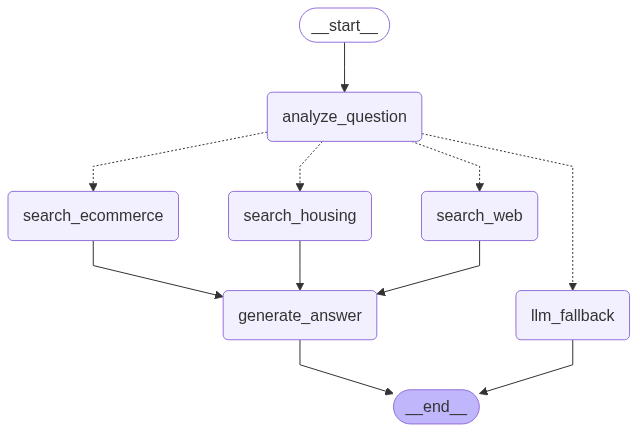

In [194]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_ecommerce": ecommerce_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback
}

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_ecommerce", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_ecommerce", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", END)
search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
rag_search_graph = search_builder.compile()

# 그래프 시각화 
display(Image(rag_search_graph.get_graph().draw_mermaid_png()))

In [195]:
inputs = {"question": "중고나라에서 물건을 구입했는데 물품이 안와요."}
for output in rag_search_graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_ecommerce']}"

----------------------------------------------------------

--- 전자상거래법 전문가 에이전트 시작 ---
---문서 검색 (전자상거래법)---
---정보 추출 및 평가 (전자상거래법)---
---1차 답변 생성 (전자상거래법 기반)---
---문서 검색 (소비자기본법)---
---정보 추출 및 평가 (소비자기본법)---
---최종 통합 답변 생성---
"Node 'search_ecommerce':"
("Value: {'answers': ['1. 질문에 대한 법률 조항 및 해석  \\n중고나라와 같은 온라인 중고거래 플랫폼에서 물건을 "
 '구입했으나 물품이 도착하지 않는 경우, 이는 민법상 매매계약 불이행(채무불이행)에 해당할 수 있습니다(민법 제390조). 만약 판매자가 '
 '고의로 물품을 보내지 않았다면 형법상 사기죄가 성립할 수도 있습니다(형법 제347조). 전자상거래법(전자상거래 등에서의 소비자보호에 관한 '
 '법률)은 주로 통신판매업자에 적용되며, 개인 간 거래(C2C)는 원칙적으로 직접 적용 대상이 아닙니다(전자상거래법 제4조). 다만, '
 '중고나라와 같은 플랫폼은 분쟁조정이나 신고 지원 등 일부 역할을 할 수 있습니다.\\n\\n2. 질문과 관련된 사례 혹은 법률 외 Q&A '
 '정보  \\n- 온라인 직거래(중고거래 앱 등)에서 피해를 입은 경우, 피해자는 관할 경찰서 민원실에 신분증, 사기피해 입증 자료(채팅 '
 '내용, 입금 내역 등)를 준비해 진정서를 작성, 제출해야 합니다. (출처: 생활법령정보 백문백답)  \\n- 중고거래 플랫폼(중고나라 '
 '등)을 통해 분쟁/불만 처리 요청을 할 수 있으며, 플랫폼 담당자가 사실 확인 후 최대 7영업일 이내에 처리 결과를 통지합니다. (출처: '
 '생활법령정보 백문백답)  \\n- 민사소송을 통해 피해 구

In [196]:
print(value)

{'final_answer': '🔍 질문 주신 내용에 대해 답변 드리겠습니다.\n\n중고나라에서 물건을 구입했으나 물품이 도착하지 않는 경우, 이는 민법상 매매계약 불이행(채무불이행)에 해당할 수 있습니다(민법 제390조).  \n만약 판매자가 고의로 물품을 보내지 않았다면 형법상 사기죄가 성립할 수도 있습니다(형법 제347조).  \n우선 판매자에게 연락하여 상황을 확인하고, 중고나라 고객센터에 분쟁/불만 처리를 요청할 수 있습니다(생활법령정보 백문백답).  \n해결되지 않을 경우, 입금 내역, 대화 내용 등 증거자료를 준비해 경찰서에 사기 피해로 신고할 수 있습니다(생활법령정보 백문백답).  \n또한, 금전적 피해에 대해 소액사건재판을 통해 민사상 손해배상을 청구할 수도 있습니다(생활법령정보 백문백답).  \n이 과정에서 플랫폼은 신고 및 자료 송부에 도움을 줄 수 있습니다(생활법령정보 백문백답).\n\n📃', 'question': '중고나라에서 물건을 구입했는데 물품이 안와요.'}


# 4. 답변 평가 및 확인

### 4-1. 답변을 평가하는 ReAct 에이전트

In [197]:
from textwrap import dedent

evaluation_prompt = dedent("""
당신은 AI 어시스턴트가 생성한 답변을 평가하는 전문가입니다. 주어진 질문과 답변을 평가하고, 60점 만점으로 점수를 매기세요. 다음 기준을 사용하여 평가하십시오:

1. 정확성 (10점)
2. 관련성 (10점)
3. 완전성 (10점)
4. 인용 정확성 (10점)
5. 명확성과 간결성 (10점)
6. 객관성 (10점)

평가 과정:
1. 주어진 질문과 답변을 주의 깊게 읽으십시오.
2. 필요한 경우, 다음 도구를 사용하여 추가 정보를 수집하세요:
   - web_search: 웹 검색
   - ecommerce_law_search: 전자상거래법 검색
   - housing_law_search: 주택임대차보호법 검색

   도구 사용 형식:
   Action: [tool_name]
   Action Input: [input for the tool]

3. 각 기준에 대해 1-10점 사이의 점수를 매기세요.
4. 총점을 계산하세요 (60점 만점).

출력 형식:
{
  "scores": {
    "accuracy": 0,
    "relevance": 0,
    "completeness": 0,
    "citation_accuracy": 0,
    "clarity_conciseness": 0,
    "objectivity": 0
  },
  "total_score": 0,
  "brief_evaluation": "간단한 평가 설명"
}

최종 출력에는 각 기준의 점수, 총점, 그리고 간단한 평가 설명만 포함하세요.
""")

In [198]:
tools

[StructuredTool(name='ecommerce_law_search', description='전자상거래 소비자보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.ecommerce_law_search'>, func=<function ecommerce_law_search at 0x11eaf09d0>),
 StructuredTool(name='cust_db_search', description='소비자 기본법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.cust_db_search'>, func=<function cust_db_search at 0x14a8eed40>),
 StructuredTool(name='road_traffic_law_search', description='\x08도로교통법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.road_traffic_law_search'>, func=<function road_traffic_law_search at 0x14a7e37f0>),
 StructuredTool(name='housing_law_search', description='주택임대차보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.housing_law_search'>, func=<function housing_law_search at 0x14ab23490>),
 StructuredTool(name='web_search', description='데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web

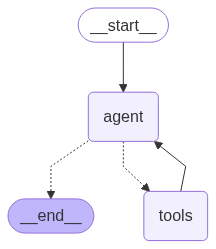

In [199]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# 그래프 생성 
answer_reviewer = create_react_agent(
    llm, 
    tools=tools, 
    # state_modifier=evaluation_prompt,
    prompt=evaluation_prompt,
    )

# 그래프 출력
display(Image(answer_reviewer.get_graph().draw_mermaid_png()))

In [200]:
# 그래프 실행
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content=f"""[질문]\n\{value['question']}n\n[답변]\n{value['final_answer']}""")]
messages = answer_reviewer.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

[질문]
\중고나라에서 물건을 구입했는데 물품이 안와요.n
[답변]
🔍 질문 주신 내용에 대해 답변 드리겠습니다.

중고나라에서 물건을 구입했으나 물품이 도착하지 않는 경우, 이는 민법상 매매계약 불이행(채무불이행)에 해당할 수 있습니다(민법 제390조).  
만약 판매자가 고의로 물품을 보내지 않았다면 형법상 사기죄가 성립할 수도 있습니다(형법 제347조).  
우선 판매자에게 연락하여 상황을 확인하고, 중고나라 고객센터에 분쟁/불만 처리를 요청할 수 있습니다(생활법령정보 백문백답).  
해결되지 않을 경우, 입금 내역, 대화 내용 등 증거자료를 준비해 경찰서에 사기 피해로 신고할 수 있습니다(생활법령정보 백문백답).  
또한, 금전적 피해에 대해 소액사건재판을 통해 민사상 손해배상을 청구할 수도 있습니다(생활법령정보 백문백답).  
이 과정에서 플랫폼은 신고 및 자료 송부에 도움을 줄 수 있습니다(생활법령정보 백문백답).

📃
================================== Ai Message ==================================

{
  "scores": {
    "accuracy": 9,
    "relevance": 10,
    "completeness": 9,
    "citation_accuracy": 7,
    "clarity_conciseness": 9,
    "objectivity": 10
  },
  "total_score": 54,
  "brief_evaluation": "답변은 중고거래 미배송 문제에 대해 민사·형사적 대응, 신고 절차, 증거 준비 등 실질적이고 구체적인 조언을 제공하여 정확성과 완전성이 높습니다. 다만, 인용 출처가 '생활법령정보 백문백답'으로만 반복적으로 표기되어 구체적 조항이나 정확한 인용이 부족한 점이 아쉽습니다. 전반적으로

In [201]:
json.loads(m.content).keys()

dict_keys(['scores', 'total_score', 'brief_evaluation'])

In [202]:
print(json.loads(m.content)['total_score'])

54


### 4-2. HITL:답변 평가 내용을 확인 

In [203]:
# 답변 평가하는 노드를 추가
def evaluate_answer_node(state:ResearchAgentState):
    question = state["question"]
    final_answer = state["final_answer"]

    messages = [HumanMessage(content=f"""[질문]\n\{question}n\n[답변]\n{final_answer}""")]
    response = answer_reviewer.invoke({"messages": messages})
    response_dict = json.loads(response['messages'][-1].content)

    return {"evaluation_report": response_dict, "question": question, "final_answer": final_answer}

# HITL 조건부 엣지 정의
def human_review(state: ResearchAgentState):
    print("\n현재 답변:")
    print(state['final_answer'])
    print("\n평가 결과:")
    print(f"총점: {state['evaluation_report']['total_score']}/60")
    print(state['evaluation_report']['brief_evaluation'])
    
    user_input = input("\n이 답변을 승인하시겠습니까? (y/n): ").lower()
    
    if user_input == 'y':
        return "approved"
    else:
        return "rejected"
    

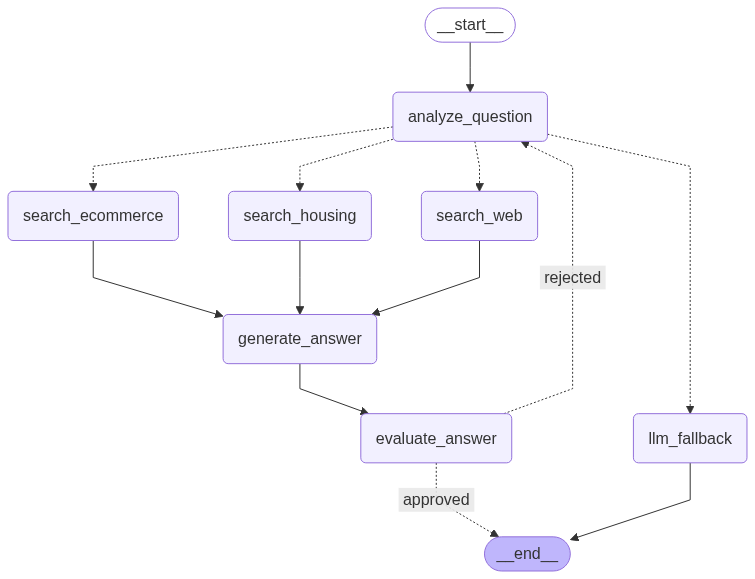

In [204]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_ecommerce": ecommerce_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
}

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_ecommerce",  "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_ecommerce","search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", "evaluate_answer")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "evaluate_answer",
    human_review,
    {
        "approved": END,
        "rejected": "analyze_question"  # 승인되지 않은 경우 질문 분석 단계로 돌아감
    }
)

search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
legal_rag_agent = search_builder.compile()

# 그래프 시각화 
display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [165]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_housing']}"

----------------------------------------------------------

--- 주택임대차보호법 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---쿼리 재작성---


KeyboardInterrupt: 

In [49]:
value

{'question': '대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?',
 'final_answer': '아파트 임대차 계약을 대리인과 체결할 때 주의해야 할 점은 다음과 같습니다.\n\n1. 대리인의 권한을 반드시 확인해야 하며, 위임장과 신분증을 확인해야 합니다. 위임장에는 임대인의 인감도장이 날인되어 있어야 하며, 임대인의 인감증명서와 신분증 사본도 함께 확인하는 것이 안전합니다 (네이버 블로그, https://m.blog.naver.com/mathmaster7668/223053556755; https://blog.naver.com/lawyerkim20/223862706792).\n\n2. 임대차계약서에는 계약 상대방이 소유자가 아닌 ‘소유자의 대리인’임을 특약란에 명확히 기재해야 하며, 민법 제115조에 따라 대리계약임을 표시하지 않으면 대리인이 자기 명의로 계약한 것으로 간주될 수 있으므로 반드시 대리계약임을 표시해야 합니다 (네이버 블로그, https://m.blog.naver.com/mathmaster7668/223053556755; https://blog.naver.com/lawyerkim20/223862706792).\n\n3. 임대차계약의 주요 정보(확정일자, 차임, 보증금 등)와 납세증명서(또는 열람 동의서) 제시 여부를 반드시 확인해야 하며, 이는 임차인의 권리 보호와 계약의 적법성을 위해 중요합니다 (주택임대차보호법 제3조의7 제1호, 제2호).\n\n4. 공인중개사가 모든 서류를 준비하더라도 임대인 본인과의 통화 등으로 실제 위임 여부를 재차 확인하는 것이 안전합니다 (네이버 블로그, https://m.blog.naver.com/mathmaster7668/223053556755; https://blog.naver.com/lawyerkim20/223862706792).\n\n이러한 절차를 꼼꼼히 지키면 향후 분쟁을 예방할 수 있습니다 (주택임대차보호법 제3조의7 제1호, 제2호; 네이버 블로그, https://

In [50]:
inputs = {"question": "렌트카에서 교통사고 발생시 어떻게 처리되나요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_web']}"

----------------------------------------------------------

--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
"Node 'search_web':"
("Value: {'answers': ['1. 질문에 대한 직접적인 답변  \\n렌트카를 이용 중 교통사고가 발생하면, 우선 침착하게 사고 "
 '현장을 파악하고 인명 피해가 있을 경우 즉시 119(응급) 또는 112(경찰)에 신고해야 합니다. 이후 렌트카 업체에 사고 사실을 '
 '신속하게 알리고, 보험 처리 절차를 안내받아 따라야 합니다. 이때 면책금(자기부담금) 등 보험 관련 조건도 반드시 확인해야 합니다. '
 '(출처: i-see-sun.tistory.com, gunsoul.tistory.com)\\n\\n2. 관련 출처 및 링크  \\n- '
 '[렌트카 이용 중 사고 발생 시 대처 방법과 보험 처리 '
 '절차](https://i-see-sun.tistory.com/entry/렌트카-이용-중-사고-발생-시-대처-방법과-보험-처리-절차) '
 '(출처: i-see-sun.tistory.com)  \\n- [렌트카 이용중 사고 처리방법, 렌트카 사고 처리 방법 및 '
 '순서](https://gunsoul.tistory.com/entry/렌트카-이용중-사고-처리방법-렌트카-사고-처리-방법-및-순서) '
 '(출처: gunsoul.tistory.com)\\n\\n3. 추가 설명 또는 예시  \\n예를 들어, 사고가 발생했을 때 다음과 같은 '
 '순서로 처리하면 됩니다:  \\n1) 인명 피해 여부 확인 및 119/112 신고  \\n2) 사고 현장 사진 촬영 및 증거 확보  '
 '\\n3) 렌트카 업체에 사고 사실 신고  \\n4) 보험사 또는 렌트카 업체의 안내에 

In [51]:
value

{'question': '렌트카에서 교통사고 발생시 어떻게 처리되나요?',
 'final_answer': '렌트카 이용 중 교통사고가 발생하면, 우선 인명 피해 여부를 확인하고 필요시 119(응급) 또는 112(경찰)에 신고해야 합니다. 이후 사고 현장 사진 촬영 등 증거를 확보한 뒤, 렌트카 업체에 사고 사실을 신속하게 알리고 보험 처리 절차를 안내받아 따라야 합니다. 이 과정에서 면책금(자기부담금) 등 보험 관련 조건도 반드시 확인해야 하며, 필요시 경찰서 방문 및 사고 경위 진술이 필요할 수 있습니다. 사고 처리 과정에서 보험 조건과 면책금 등도 꼼꼼히 확인하는 것이 중요합니다 (출처: i-see-sun.tistory.com, gunsoul.tistory.com).',
 'evaluation_report': {'scores': {'accuracy': 9,
   'relevance': 10,
   'completeness': 9,
   'citation_accuracy': 6,
   'clarity_conciseness': 9,
   'objectivity': 9},
  'total_score': 52,
  'brief_evaluation': '답변은 렌트카 사고 시 기본적인 처리 절차(인명 확인, 신고, 증거 확보, 업체 통보, 보험 확인 등)를 잘 설명하고 있습니다. 다만, 인용한 출처가 공식 기관이 아닌 블로그로 신뢰도가 다소 떨어지며, 법적 근거(예: 도로교통법, 자동차손해배상보장법 등) 언급이 없어 인용 정확성 점수를 낮게 평가했습니다. 전반적으로 실무적 안내는 충실하나, 공식성·법적 근거 보강이 필요합니다.'}}

# 5. Gradio 챗봇

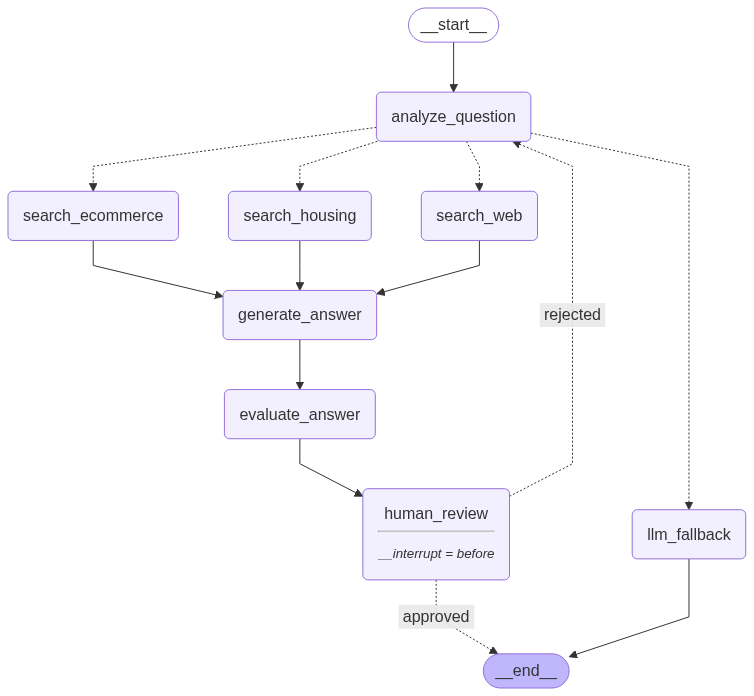

In [205]:
from langgraph.checkpoint.memory import MemorySaver

# HITL 노드로 변경 (그라디오에서 입력을 처리)
def human_review(state: ResearchAgentState):
    pass

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_ecommerce": ecommerce_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
    "human_review": human_review,
}

for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_ecommerce", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_ecommerce", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", "evaluate_answer")
search_builder.add_edge("evaluate_answer", "human_review")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "human_review",
    lambda x: "approved" if x.get("user_decision") == "approved" else "rejected",
    {
        "approved": END,
        "rejected": "analyze_question"
    }
)

search_builder.add_edge("llm_fallback", END)

# 메모리 추가
memory = MemorySaver()

# 그래프 컴파일 (Breakpoint 설정)
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 그래프 시각화 
display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [ ]:
# import gradio as gr
# import uuid
# from typing import List, Tuple
# from langgraph.checkpoint.memory import MemorySaver

# # 메모리 사용 준비
# memory = MemorySaver()
# legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# # 예시 질문들
# example_questions = [
#     "사업장에서 CCTV를 설치할 때 주의해야 할 법적 사항은 무엇인가요?",
#     "전월세 계약 갱신 요구권의 행사 기간과 조건은 어떻게 되나요?",
#     "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?",
#     "번개 장터에서 물건을 샀는데 벽돌이 왔어요. 어떤 조치를 취할 수 있을까요?",
# ]

# # 챗봇 클래스 생성
# class ChatBot:
#     def __init__(self):
#         self.thread_id = str(uuid.uuid4())
#         self.user_decision = False

#     def process_message(self, message: str) -> str:
#         try:
#             config = {"configurable": {"thread_id": self.thread_id}}
            
#             if not self.user_decision:
#                 # Breakpoint 까지 먼저 실행
#                 inputs = {"question": message}
#                 legal_rag_agent.invoke(inputs, config=config)

#                 # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
#                 current_state = legal_rag_agent.get_state(config)
#                 print("Current state:", current_state)
                
#                 final_answer = current_state.values.get("final_answer", "No answer available")
#                 evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                
#                 response = f"""현재 답변:
#             {final_answer}

#             평가 결과:
#             총점: {evaluation_report.get('total_score', 0)}/60
#             {evaluation_report.get('brief_evaluation', 'No evaluation available')}

#             이 답변을 승인하시겠습니까? (y/n): """
                
#                 # 사용자 승인 여부를 True로 변경 
#                 self.user_decision = True
#                 return response
                
#             else:
#                 # 사용자 입력에 따라 다음 경로를 선택
#                 user_decision = message.lower()
#                 if user_decision == 'y':
#                     self.user_decision = False # 초기화 
#                     # 상태 업데이트 - 질문을 수정하여 업데이트
#                     legal_rag_agent.update_state(config, {"user_decision": "approved"})
#                     # 나머지 작업을 이어서 진행 
#                     legal_rag_agent.invoke(None, config=config)
#                     # 작업이 종료되고 최종 상태의 메시지를 출력 
#                     current_state = legal_rag_agent.get_state(config)
#                     print("Final state:", current_state)
#                     return current_state.values.get("final_answer", "No final answer available")
#                 else:
#                     self.user_decision = False # 초기화 
#                     # 상태 업데이트 - 질문을 수정하여 업데이트
#                     legal_rag_agent.update_state(config, {"user_decision": "rejected"})
#                     # 나머지 작업을 이어서 진행 
#                     legal_rag_agent.invoke(None, config=config)
#                     # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
#                     current_state = legal_rag_agent.get_state(config)
#                     print("Revised state:", current_state)
                    
#                     final_answer = current_state.values.get("final_answer", "No answer available")
#                     evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                    
#                     response = f"""다시 생성한 답변:
#                 {final_answer}

#                 평가 결과:
#                 총점: {evaluation_report.get('total_score', 0)}/60
#                 {evaluation_report.get('brief_evaluation', 'No evaluation available')}

#                 이 답변을 승인하시겠습니까? (y/n): """
                    
#                     # 사용자 승인 여부를 True로 변경 
#                     self.user_decision = True
#                     return response

#         except Exception as e:
#             print(f"Error occurred: {str(e)}")
#             return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."

#     def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
#         print(f"Thread ID: {self.thread_id}")
#         response = self.process_message(message)
#         return response

# chatbot = ChatBot()

# # ChatInterface 생성
# demo = gr.ChatInterface(
#     fn=chatbot.chat,
#     title="로키비키와 법률 상담",
#     description="생활 법률 고민이 생겼을 때, 24시간 언제든 로키비키 럭키비키한 하루🍀",
#     examples=example_questions,
#     theme=gr.themes.Soft(),
    
# )

# # Gradio 앱 실행
# demo.launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [207]:
import gradio as gr
import uuid
from typing import List, Tuple

# 예시 질문
# example_questions = [
#     "사업장에서 CCTV를 설치할 때 주의해야 할 법적 사항은 무엇인가요?",
#     "전월세 계약 갱신 요구권의 행사 기간과 조건은 어떻게 되나요?",
#     "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?",
#     "번개 장터에서 물건을 샀는데 벽돌이 왔어요. 어떤 조치를 취할 수 있을까요?",
# ]

# 메모리 사용 준비
memory = MemorySaver()
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 테스트용 목업
# def mock_legal_agent(question: str) -> str:
#     return f"""답변: '{question}'에 대한 답변입니다. 판매자와 연락 후 해결되지 않으면 민사소송이 가능합니다.
# 관련 법령: ["민법 제390조", "형법 제347조", "전자상거래법 제17조"]"""

# 챗봇 클래스 정의
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def process_message(self, message: str) -> str:
        config = {"configurable": {"thread_id": self.thread_id}}
        try:
            inputs = {"question": message}
            legal_rag_agent.invoke(inputs, config=config)
            current_state = legal_rag_agent.get_state(config)
            final_answer = current_state.values.get("final_answer", "No answer available")
            return final_answer
        except Exception as e:
            return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."
        # return mock_legal_agent(message)  # 테스트 시 목업 함수 사용
        
    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        return self.process_message(message)

chatbot = ChatBot()

# 사용자 정의 CSS
custom_css = """
/* 타이틀 영역 */
h1 {
    background: linear-gradient(90deg, #60A5FA, #2563EB);
    color: white !important;
    padding: 1.2rem;
    border-radius: 12px;
    text-align: left;
    font-size: 1.6rem;
}

/* 설명 영역도 동일한 그라데이션 + 중앙 정렬 */
p {
    color: #111827;
    padding: 0.8rem;
    border-radius: 12px;
    text-align: center !important;
    font-weight: 400;
    font-size: 1rem;
    margin-bottom: 1.2rem;
}


/* 사용자 메시지 말풍선 */
.message.user {
    background-color: #E0F2FE !important;
    color: #111827 !important;
    border-radius: 20px 20px 4px 20px;  /* 둥글게 */
    padding: 7px !important;
    font-weight: 500;
    text-align: left !important;

}

/* 챗봇 메시지 말풍선 */
.message.bot {
    background-color: #F3F4F6 !important;
    color: #111827 !important;
    border-radius: 20px 20px 4px 20px;  /* 둥글게 */
    padding: 7px !important;
    font-weight: 500;
    text-align: left !important;

}
"""


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="로키비키와 법률 상담",
    description="생활 법률 고민이 생겼을 때, 24시간 언제든 로키비키와 럭키비키한 하루🍀",
    # examples=example_questions,
    theme=gr.themes.Soft(),
    css=custom_css,
    textbox=gr.Textbox(placeholder="궁금한 법률 문제를 입력해주세요...")
)

# 앱 실행 (로컬에서는 `demo.launch()` 사용)
demo.launch()

* Running on local URL:  http://127.0.0.1:7890
* To create a public link, set `share=True` in `launch()`.


In [54]:
# demo.close()

Thread ID: 2d247310-7705-4385-8f10-7e210629cc32
--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
---최종 답변---
Current state: StateSnapshot(values={'question': '먹는샘물의 유통기한은 얼마인가요?', 'answers': ['1. 질문에 대한 직접적인 답변  \n먹는샘물의 유통기한은 일반적으로 제조일로부터 6개월입니다.  \n\n2. 관련 출처 및 링크  \n- 네이버 블로그: [먹는샘물 유통기한 6개월](https://m.blog.naver.com/neorohy/223501150848) (출처: 네이버 블로그)  \n- LFIND: [먹는샘물 유통기한 안내](https://lfind.kr/qna/88_5629) (출처: LFIND)  \n\n3. 추가 설명 또는 예시  \n만약 6개월을 초과하여 유통기한을 설정하려면, 해당 기간 동안 제품의 품질 변화가 없다는 것을 과학적으로 입증해야 하며, 시·도지사(또는 특별시장·광역시장 등)의 승인을 받아야 합니다. 즉, 일반적으로는 6개월이지만, 예외적으로 더 긴 유통기한을 인정받으려면 추가적인 절차가 필요합니다. (출처: [네이버 블로그](https://m.blog.naver.com/neorohy/223501150848), [LFIND](https://lfind.kr/qna/88_5629))  \n\n4. 결론 및 요약  \n먹는샘물의 유통기한은 제조일로부터 6개월로 정해져 있으며, 이를 초과하려면 과학적 입증과 행정적 승인이 필요합니다. 따라서 일반적으로는 6개월 이내에 섭취하는 것이 권장됩니다. (출처: [네이버 블로그](https://m.blog.naver.com/neorohy/223501150848), [LFIND](https://lfind.kr/qna/88_5629))'], 'final_answer': '먹는샘물의 유통기한은 일반적으로 제조일로부터 6개월입